# A lighter sandbox for quick development and ensembling of components
## Currently in progress: pipeline for route shape SQL query through Carto
## Objectives:
0. determine which route to use (may have different routes for a given bus line)
1. generate a gpd and a shapefile for route shape
2. plot the route on canvas and on gmap API

In [1]:
# import packages
from __future__ import print_function, division

import os
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import calendar
from datetime import datetime

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Yuwen/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import fiona
import geopandas as gpd
from shapely.geometry import Point

In [3]:
# import with py 2 and py 3 compatibility
try:
    import urllib2
    from urllib2 import HTTPError
    from urllib2 import urlopen
    from urllib import urlencode
    from StringIO import StringIO as io

except ImportError:
    import urllib
    from urllib.error import HTTPError
    from urllib.request import urlopen, Request
    from urllib.parse import urlencode
    from io import BytesIO as io

import ast

In [9]:
from fetchbus import bus_data, plot_tsd

In [10]:
# load historical AVL data
df = pd.read_csv("B54-Tue-180403-170417-5.csv")
df.head()

,Unnamed: 0,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,ProgressRate,ProgressStatus,PublishedLineName,RecordedAtTime,SituationSimpleRef,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber
0,0,186.685970,MTA NYCT_FP_B8-Weekday_C_FP_58440_B54-214,4672.19,2018-04-03,MTA NYCT_FP_B8-Weekday-098600_B54_214,DNTWN BKLYN JAY ST via MYRTLE,MTA_801134,1,12.00,...,normalProgress,NaN,B54,2018-04-03T17:03:54.000-04:00,MTABC_3eb852e7-605a-487e-9c33-5e34b9a09b0a,MYRTLE AV/GRAND AV,MTA_304440,0,MTA NYCT_3974,1
1,1,186.467670,MTA NYCT_FP_B8-Weekday_C_FP_51900_B54-218,3646.53,2018-04-03,MTA NYCT_FP_B8-Weekday-100200_B54_223,DNTWN BKLYN JAY ST via MYRTLE,MTA_801134,1,16.41,...,normalProgress,NaN,B54,2018-04-03T17:03:44.000-04:00,MTABC_3eb852e7-605a-487e-9c33-5e34b9a09b0a,MYRTLE AV/NOSTRAND AV,MTA_304434,0,MTA NYCT_6548,1
2,2,329.523380,MTA NYCT_FP_B8-Weekday_C_FP_26040_B26-16,7025.20,2018-04-03,MTA NYCT_FP_B8-Weekday-096600_B54_213,RIDGEWOOD TERM via MYRTLE,MTA_901258,0,25.41,...,noProgress,layover,B54,2018-04-03T17:04:05.000-04:00,MTABC_3eb852e7-605a-487e-9c33-5e34b9a09b0a,PALMETTO ST/ST NICHOLAS AV,MTA_901258,0,MTA NYCT_7261,1
3,3,6.652087,MTA NYCT_FP_B8-Weekday_C_FP_54780_B54-219,5570.10,2018-04-03,MTA NYCT_FP_B8-Weekday-098200_B54_219,RIDGEWOOD TERM via MYRTLE,MTA_901258,0,25.64,...,normalProgress,NaN,B54,2018-04-03T17:03:54.000-04:00,MTABC_3eb852e7-605a-487e-9c33-5e34b9a09b0a,MYRTLE AV/DE KALB AV,MTA_304409,0,MTA NYCT_6541,1
4,4,357.805050,MTA NYCT_FP_B8-Weekday_C_FP_17820_B54-205,1168.30,2018-04-03,MTA NYCT_FP_B8-Weekday-101400_B54_222,RIDGEWOOD TERM via MYRTLE,MTA_901258,0,38.94,...,normalProgress,NaN,B54,2018-04-03T17:04:00.000-04:00,MTABC_3eb852e7-605a-487e-9c33-5e34b9a09b0a,MYRTLE AV/ST EDWARDS ST,MTA_306931,0,MTA NYCT_6578,1


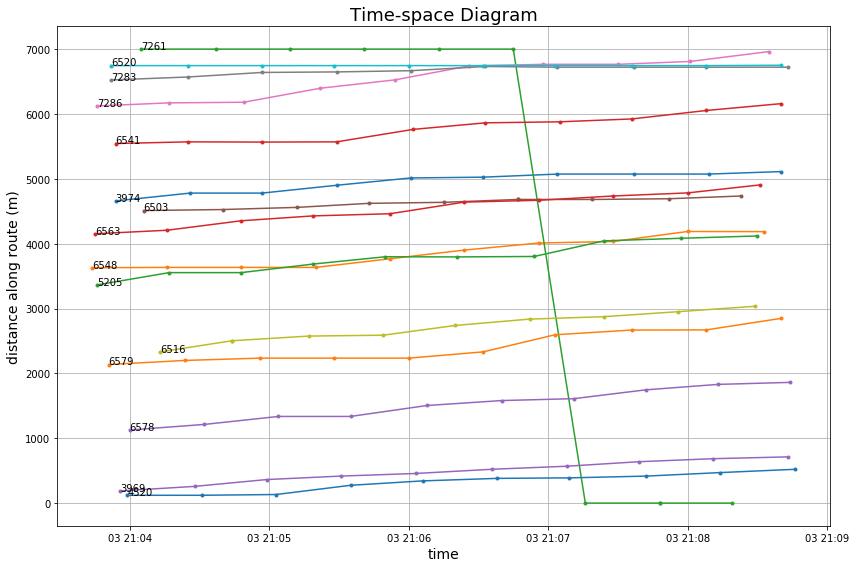

(<matplotlib.figure.Figure at 0x10f7b0f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f97ba20>)

In [19]:
plot_tsd(df)

In [49]:
# load historical AVL data
df = pd.read_csv("M15-0-Tue-2018320-205154-180.csv")
df.head()

,Unnamed: 0,Latitude,Longitude,RecordedAtTime,StopName,StopStatus,VehDistAlongRoute,VehicleRef
0,0,40.777123,-73.949194,2018-03-20T20:51:38.000-04:00,1 AV/E 86 ST,at stop,8293.05,5258
1,1,40.712291,-73.994565,2018-03-20T20:51:37.000-04:00,MADISON ST/MARKET ST,approaching,2100.65,5909
2,2,40.758444,-73.962826,2018-03-20T20:51:28.858-04:00,1 AV/E 57 ST,approaching,8031.64,5703
3,3,40.718838,-73.990441,2018-03-20T20:51:46.000-04:00,ALLEN ST/DELANCEY ST,approaching,925.62,5871
4,4,40.799545,-73.932818,2018-03-20T20:51:33.000-04:00,1 AV/PALADINO AV,approaching,11142.10,6069


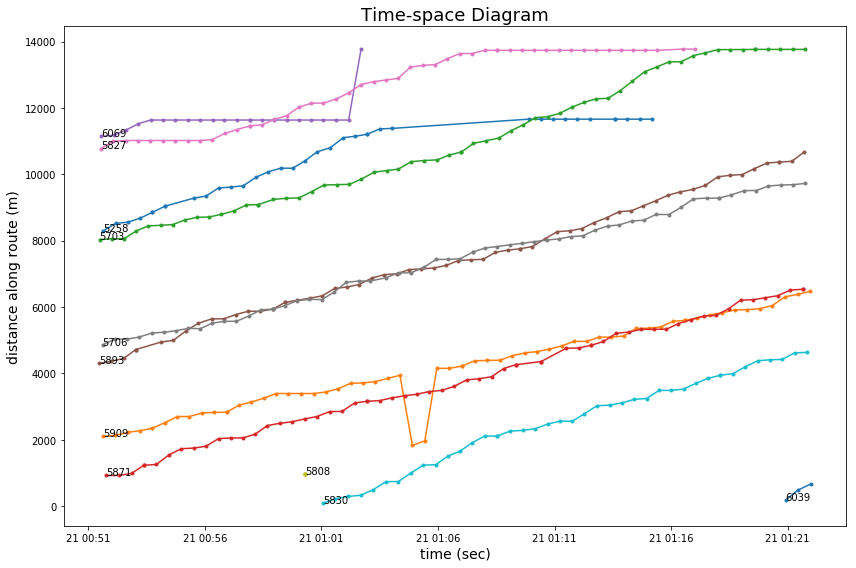

(<matplotlib.figure.Figure at 0x11c131b38>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1102de7f0>)

In [64]:
# plot the time-space diagram
plot_tsd(df, save=True, fname="test_TSD")

(<matplotlib.figure.Figure at 0x117cde828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11014c128>)

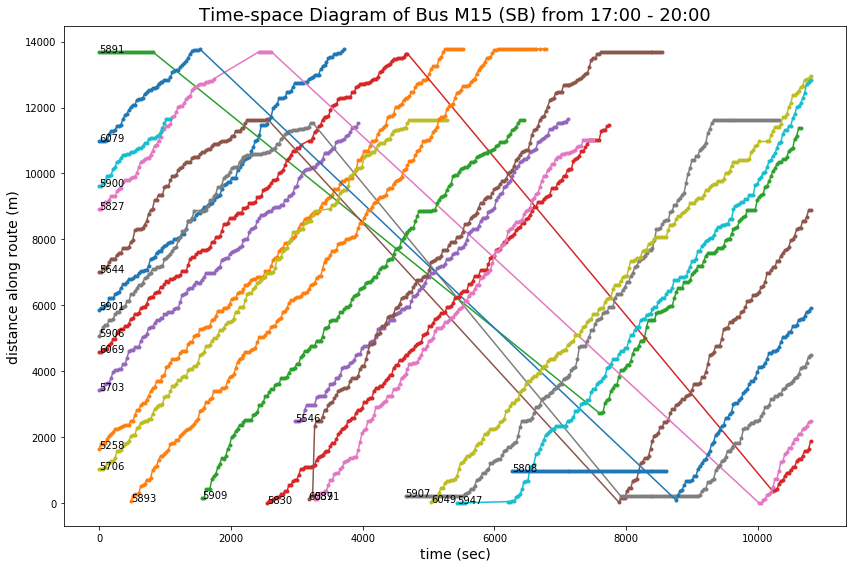

In [43]:
# plot the time-space diagram
plot_tsd(df)

## This is the previous wrong plotting

(<matplotlib.figure.Figure at 0x10f7bcdd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10876b9b0>)

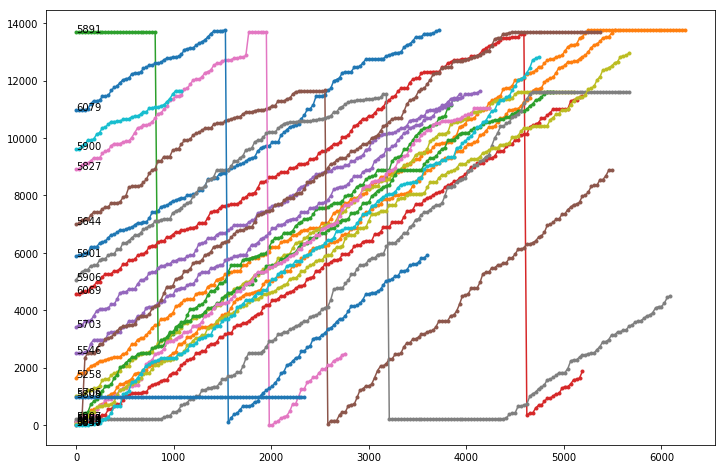

In [13]:
# plot the time-space diagram
plot_tsd(df)

In [7]:
# set SQL source
SQL_SOURCE = 'https://ywc249.carto.com/api/v2/sql?q='

# define query function
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """
    Queries carto datasets from a given carto account
    
    ARGUMENTS
    ----------
    query: a valid sql query string
    format: outlut format (default: CSV)
    source: a valid sql api endpoint OPTIONAL (default: Carto ywc249 account)

    RETURN
    ----------
    - the return of the sql query AS A STRING
    
    NOTES
    ----------
    designed for the carto API, tested only with CSV return format
    """
    
    data = urlencode({'format':format, 'q':query}).encode('utf-8')
    try:
        response = urlopen(source, data)
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [8]:
# make query for a given route
# the shape.txt files are pre-uploaded to my Carto space as csv files
route = 'M15'
boro = route[0].lower() # make query from respecttive GTFS shape csv

test = '''
SELECT *
FROM shapes_{}
WHERE shape_id LIKE '{}%'
ORDER BY shape_id, shape_pt_sequence
'''.format(boro, route)

shape = pd.read_csv(io(queryCartoDB(test)), sep=',')
shape.head()

,the_geom,cartodb_id,the_geom_webmercator,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,NaN,17218,NaN,M150402,40.803181,-73.932487,10001
1,NaN,17219,NaN,M150402,40.803318,-73.932816,10002
2,NaN,17220,NaN,M150402,40.803356,-73.932921,10003
3,NaN,17221,NaN,M150402,40.803422,-73.933083,10004
4,NaN,17222,NaN,M150402,40.802753,-73.933571,10005


In [ ]:
#for r, d in data.iterrows():

In [9]:
# create Point geom
shape['the_geom'] = [Point(shape.iloc[i,5], shape.iloc[i,4]) for i in range(len(shape))]
shape.head()

,the_geom,cartodb_id,the_geom_webmercator,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,POINT (-73.93248699999999 40.803181),17218,NaN,M150402,40.803181,-73.932487,10001
1,POINT (-73.932816 40.803318),17219,NaN,M150402,40.803318,-73.932816,10002
2,POINT (-73.93292099999999 40.803356),17220,NaN,M150402,40.803356,-73.932921,10003
3,POINT (-73.933083 40.803422),17221,NaN,M150402,40.803422,-73.933083,10004
4,POINT (-73.933571 40.802753),17222,NaN,M150402,40.802753,-73.933571,10005


In [10]:
shape_gdf = gpd.GeoDataFrame(shape)

In [25]:
# this is a fix patch for previous versions of downloaded data
mod = list(df['Unnamed: 0'])
tiempo = 0
ts = []
for i,v in enumerate(mod[:-1]):
    ts.append(tiempo)
    if mod[i+1] < mod[i]:
        tiempo += 30
    else:
        continue
ts.append(ts[-1])
df['ts'] = ts